# Immigration Data Analysis 
### Data Engineering Capstone Project

#### Project Summary
The goal of this project is to create an Airflow pipeline using I94 immigration data and city Demography data to load the data in an AWS cluster and then perform analysis to find out answer to questions.

    *Analysis*: Does the city with most number of foreign born has the most number of i94 travellers?


The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

### Step 1: Scope the Project and Gather Data

#### Scope 

The scope of the project is to build an automated pipeline in which redshift cluster is created,clean data is loaded in the cluster from multiple data sources (local, S3) of different data formats (SAS,.csv) and then analysis is performed to gather information from data.

I am using the Udacity provided data.


#### Describe and Gather Data 

I decided to go with the Udacity provided data
  *  **I94 Immigration Data**: This data comes from the US National Tourism and Trade Office found here. Each report contains international visitor arrival statistics by world regions and select countries (including top 20), type of visa, mode of transportation, age groups, states visited (first intended address only), and the top ports of entry (for select countries). It is provided in SAS7BDAT format which is a binary database storage format

  * **U.S. City Demographic Data**: This dataset contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000. Dataset comes from OpenSoft found here.
    
  * **Airport Code Table**: This is a simple table of airport codes and corresponding cities. The airport codes may refer to either IATA airport code, a three-letter code which is used in passenger reservation, ticketing and baggage-handling systems, or the ICAO airport code which is a four letter code used by ATC systems and for airports that do not have an IATA airport code (from wikipedia). It comes from here.

### Step 2: Explore and Assess the Data

#### 2.1 Explore the Data 
**Immigration Data**
Since the data is too huge to explore it in excel or dataframe, i prefer to load everything and then run the SQL statements to understand it more. 

I have prepared SQL, which will give me meaningful answers about the data and also the quality issue in the data.

I created seaparate tables as per I94_SAS_LABELS_Description for validating the country, port, mode and address

* **Finding the number of records where i94cit are not valid**

```
  select * from public."immigration" i
  where not exists (select 1 from country c
  where i.i94cit=c.code)
  ```
        
  gives
 
 | count|
 |------|
| 1 |


* **Finding the number of records where i94port  are not valid**

``` 
select count(*) from public."immigration" i
  where not exists (select 1 from port c
  					where i.i94port=c.code
        				and c.port_name not like 'No PORT Code%')
                        
```
 
 gives
 
| count|
 |------|
| 5 |
 
* **Finding the number of records where i94addr  are not valid**
 
```
select count(*) from public."immigration" i
  where not exists (select 1 from address c
  					where i.i94addr=c.code
   				 )
 ```
  
  gives
  
| Count |
|------|
|   239  |

* **Finding the number of records where i94mode  are not valid**

```
select count(*) from public."immigration"
where i94mode is null
```

gives

| Count |
|------|
|   1  |

Looking at above exploration steps, we can asses that there are some unwanted records present in
i94mode, i94addr, i94port, i94cit and we can take the opportunity to clean them.

**U.S. City Demographic Data**
This dataset looks clean and i have uploaded the file to S3 




#### 2.2 Cleaning Steps
1.) Load the data in the dataframes and then run the below cleaning steps
        * load data in dataframes. For, immigration file, use read_sas and for csv file, use read_csv 
        * apply panda filters to remove the not null, invalid data in immigration file as discussed above



In [1]:
import pandas as pd
import boto3
import json

# Working on smaller dataset as it will take time to load all the files
reader_sas = pd.read_sas('i94_apr16_sub.sas7bdat',encoding='ISO-8859-1',chunksize=5000,iterator=True)

In [2]:
immigration_df = reader_sas.read()

In [3]:
immigration_df.head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,NaN,NaN,...,U,NaN,1979.0,10282016,NaN,NaN,NaN,1.897628e+09,NaN,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,NaN,1991.0,D/S,M,NaN,NaN,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,NaN,M,1961.0,09302016,M,NaN,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,1988.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,2012.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2


In [4]:
immigration_df.shape

(5000, 28)

Removing the data where i94mode is null

In [5]:
immigration_df = immigration_df[immigration_df.i94mode.notnull()]

In [6]:
immigration_df.shape

(4999, 28)

In [7]:
country_df = pd.read_csv('cntyl.csv',delimiter='=', header=None, names=['country_code','country_name'])
country_df=country_df.replace(regex=[r'\''],value='')

In [8]:
country_df.head()

,country_code,country_name
0,582,"MEXICO Air Sea, and Not Reported (I-94, no l..."
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA


In [9]:
immigration_df = immigration_df[immigration_df.i94cit.isin(country_df.country_code)]
immigration_df = immigration_df[immigration_df.i94res.isin(country_df.code)]

In [10]:
immigration_df.shape

(4998, 28)

In [11]:
address_df = pd.read_csv('I94ADDR.csv',delimiter='=', header=None, names=['code','state_name'])
address_df=address_df.replace(regex=[r'\''],value='')

In [12]:
immigration_df = immigration_df[immigration_df.i94addr.isin(address_df.code)]

In [13]:
immigration_df.shape

(4759, 28)

In [27]:
port_df = pd.read_csv('I94PORT.csv',delimiter='=', header=None, names=['code','port_name'])
port_df=port_df.replace(regex=[r'\t|\''],value='')

In [28]:
port_df.shape


(660, 2)

In [29]:
port_df.head()

,code,port_name
0,ALC,"ALCAN, AK"
1,ANC,"ANCHORAGE, AK"
2,BAR,"BAKER AAF - BAKER ISLAND, AK"
3,DAC,"DALTONS CACHE, AK"
4,PIZ,"DEW STATION PT LAY DEW, AK"


In [30]:
port_df=port_df[~(port_df.port_name.str.contains('No PORT Cod'))]

In [31]:
port_df.shape

(600, 2)

In [32]:
immigration_df = immigration_df[immigration_df.i94port.isin(port_df.code)]
immigration_df.shape

(4754, 28)

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model

* *immigration* table which contain the immigration events after the dataframe is cleaned.
* *country* which contains all the list of countries as mentioned in the SAS description table for i94cit, i94res
* *address* which contains the list of valid states 
* *port* which contains the list of ports
* *us_city_demography* which contains the US Demogrpahy data



#### 3.2 Mapping Out Data Pipelines
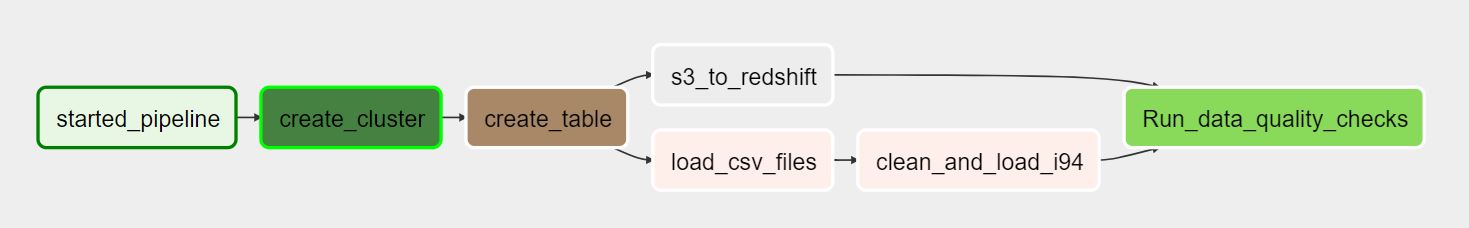


**Create the fully automated pipeline. As part of this pipeline,**
* *Create the REDSHIFT Cluster and then Create an Airflow Connection*
    ```
     try:
            response = redshift.create_cluster(
                ClusterType=DWH_CLUSTER_TYPE,
                NodeType=DWH_NODE_TYPE,
                NumberOfNodes=DWH_NUM_NODES,
                DBName=DWH_DB,
                ClusterIdentifier=DWH_CLUSTER_IDENTIFIER,
                MasterUsername=DWH_DB_USER,
                MasterUserPassword=DWH_DB_PASSWORD,
                IamRoles=[roleArn]
                )
        except Exception as e:
            self.log.info(e)
    ```

    ```
    connection_setup = Connection(
                conn_id="pipeline_redshift",
                schema=DWH_DB,
                conn_type="postgres",
                host=DWH_ENDPOINT,
                login=DWH_DB_USER,
                password=DWH_DB_PASSWORD,
                port=DWH_PORT
                )
        session = settings.Session()
        session.add(connection_setup)
        session.commit()
      ```
* *Create the tables in the database: refer sql_queries.py and use the connection of cluster created above*
    ```
            session = settings.Session()
            connection_detail = session.query(Connection).filter(Connection.conn_id == 'pipeline_redshift').first()
            logging.info(connection_detail.host)
            DWH_DB_USER = connection_detail.login
            DWH_DB_PASSWORD = connection_detail.password
            DWH_ENDPOINT = connection_detail.host
            DWH_PORT = connection_detail.port
            DWH_DB = connection_detail.schema
     ```

* *Load the CSV data of country, address, port, visa types into Redshift*
* *Clean I94 data as described in step 2.2 to create dataframe df_immigration and the load it in Immigration table*
* *Load the Demogrpahy data from the S3*
    ```
    COPY {schema}.{table}
            FROM 's3://{s3_bucket}/{s3_key}'
            with credentials
            'aws_access_key_id={access_key};aws_secret_access_key={secret_key}'
            {copy_options}
            ;
    ```
* *Data Quality Check: Validating the count of data*

    ```
                     select count(*)
                 from {};
    ```
* *Run the analysis* :  Does the state with most number of foreign born has the most number of i94 travellers?

                        After running the below 2 queries it looks like the answer is no as NewYork has 
                        the most number of travellers but California has the most number of foreign born people

**Query 1**
```
select
                a.state_name,
                d.state_code,
                i.count_of_travellers,
                d.no_of_foreign_born     
            from
                (select
                    i94addr,
                    count(*) count_of_travellers                          
                from
                    immigration i                            
                group by
                    i94addr) i,
                (select
                    state_code,
                    nvl(sum(no_of_foreign_born),
                    0) no_of_foreign_born                          
                from
                    us_city_demography                          
                group by
                    state_code)d,
                address a   
            where
                i.i94addr=d.state_code       
                and a.code=d.state_code 
                order by 3 desc
                
                
                
 ```
**Query 2**
```
select
                a.state_name,
                d.state_code,
                i.count_of_travellers,
                d.no_of_foreign_born     
            from
                (select
                    i94addr,
                    count(*) count_of_travellers                          
                from
                    immigration i                            
                group by
                    i94addr) i,
                (select
                    state_code,
                    nvl(sum(no_of_foreign_born),
                    0) no_of_foreign_born                          
                from
                    us_city_demography                          
                group by
                    state_code)d,
                address a   
            where
                i.i94addr=d.state_code       
                and a.code=d.state_code 
                order by 4 desc
              
                
 ```

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

Tables are dropped before they are created everytime

```
    DROP TABLE IF EXISTS country 

    DROP TABLE IF EXISTS visa_type
    
    DROP TABLE IF EXISTS address

    DROP TABLE IF EXISTS port 

    DROP TABLE IF EXISTS  us_city_demography 

    DROP TABLE IF EXISTS immigration
```

```
CREATE TABLE IF NOT EXISTS immigration 
                                (immigration_id int identity(1, 1) PRIMARY KEY,
                                 cicid int NOT NULL,
                                 i94yr int NOT NULL,
                                 i94mon int NOT NULL,
                                 i94cit int,
                                 i94res int,
                                 i94port char(3),
                                 arrdate int,
                                 i94mode int,
                                 i94addr char(3),
                                 depdate int,
                                 i94bir int,
                                 i94visa int,
                                 count int,
                                 dtadfile varchar,
                                 visapost char(3),
                                 occup char(3),
                                 entdepa char(1),
                                 entdepd char(1),
                                 entdepu char(1),
                                 matflag char(1),
                                 biryear int,
                                 dtaddto varchar,
                                 gender char(1),
                                 insnum varchar,
                                 airline char(3),
                                 admnum varchar,
                                 fltno varchar,
                                 visatype char(3)
                                )
```

With the help of the i94_SAS_Labels_Description, I separated and created new files and 
then new tables for
country, port, address, visa_type
    
 ```
CREATE TABLE IF NOT EXISTS country
                            (
                            code integer not null
                            constraint country_pkey primary key,
                            country_name varchar not null
                            )
 ```
 
 ```
CREATE TABLE IF NOT EXISTS visa_type
                         (
                         visa_code integer,
                         visa_name varchar
                         )
  ```
  
```
CREATE TABLE IF NOT EXISTS address
                        (
                        code char(2),
                        state_name varchar
                        )
 ```
 
 ```
CREATE TABLE IF NOT EXISTS port
                        (
                        code char(3),
                        port_name varchar
                        )
```
    CREATE TABLE IF NOT EXISTS us_city_demography
                            (city VARCHAR,
                            state VARCHAR,
                            median_age NUMERIC,
                            male_population INT4,
                            female_population INT4,
                            totalpopulation INT4,
                            no_of_veterans INT4,
                            no_of_foreign_born INT4,
                            avg_house_size NUMERIC,
                            state_code VARCHAR,
                            race VARCHAR,
                            count_value INT4
                            )
```

#### 4.2 Data Quality Checks
 
Checks is applied to ensure that atleast 1 single record is loaded. It is written in DataQualityOperator

#### 4.3 Data dictionary 
***immigration***

    immigration_id: primary key
    cicid: unique key within a month
    i94yr:  4 digit year 
    i94mon: Numeric month
    i94cit: immigrant's country of citizenship; 
    i94res: immigrant's country of residence outside US
    i94port: port of entry
    arrdate: it is the Arrival Date in the USA.
    i94mode: mode of arrival 
    i94addr: state of immigrant in US 
    depdate: Departure Date from the USA 
    i94bir: Age of Respondent in Years
    i94visa: Visa codes
    count: used for summary statistics 
    dtadfile: Character Date Field - Date added to I-94 Files - CIC does not us
    visapost: Department of State where where Visa was issued
    occup: occupation that will be performed in U.S
    entdepa: Arrival Flag - admitted or paroled into the U.S.
    entdepd: Departure Flag - Departed, lost I-94 or is deceased
    entdepu: Update Flag - Either apprehended, overstayed, adjusted to perm residence
    matflag: Match flag - Match of arrival and departure records
    biryear: 4 digit year of birth
    dtaddto:  Date to which admitted to U.S. (allowed to stay until) 
    gender: Non-immigrant sex
    insnum: INS number
    airline: Airline used to arrive in U.S
    admnum: Admission Number
    fltno: Flight number of Airline used to arrive in U.S
    visatype: Class of admission legally admitting the non-immigrant to temporarily stay in U.S



***country***

A list of countries and their codes 

    code: a numbered code
    country_name:name of a country.  

***address***
A list of the states 

    code: mostly two-letter codes for states. There's DC, GU (Guam), and 99 (All Other Codes) as well
    state_name: name of state, region, etc.

***port***

A list of the ports of arrival

    code: a short code
    port_name: the name of the port; there are some No PORT Code ([code]) values too


***visa_type***

The type of visa the immigrant is coming in on. 

    visa_code: Code for the visa
    visa_name: Name of Visa

***us_city_demography***

    city: city for which stats are present,
    state: State in which the city is present,
    median_age: Median Age of the city,
    male_population: Male population present in the city,
    female_population: Female population present in the city,
    totalpopulation: Total population present in the city,
    no_of_veterans: Number of veterans present in the city,
    no_of_foreign_born: Number of foreign born present in the city,
    avg_house_size: Average number of people in a house in that city,
    state_code: Code of the state,
    race: human race,
    count_value: Count


### 5.1 Rationale
#### 5.1.1 Tools and technologies

I choose Python2.7, Pandas, Airflow and AWS (S3, REDSHIFT) 
   * ***Python:*** Python is very vast and has lot of library support
   
   * ***Airflow:***  The Airflow Platform is a tool for describing, executing, and monitoring workflows. Rich command line utilities make performing complex surgeries on DAGs a snap.The rich user interface makes it easy to visualize pipelines running in production,monitor progress, and troubleshoot issues when needed.Apache Airflow as a Top-Level Project in January 2019 and provides . 
   
   * ***AWS:*** Cloud is very efficient and we don't need to maintain it.Also, it is cost effective. It can be scaled easily on demand with IAC. 
    
### 5.2 Updates


Tables are always dropped before created and thus if the source data is updated, the pipeline will take care of loading it from scratch and perform analysis

### 5.3 If things were different...

**The data was increased by 100x.**
If the data were increased by 100 times, then i would like to switch to SPARK in distributed cluster instead of pandas dataframe. Also, i can apply the strategy of ELT instead of ETL as doing analysis and update in database will be faster once it is loaded

**The data populates a dashboard that must be updated on a daily basis by 7am every day.**
Under this scenario, We can time the airflow scheduler to run accordingly so that it finishes by 7AM daily. We can run the scheduler in midnight depending upon the amount of data. As of now, the whole pipeline get finished in 30mins.  

**The database needed to be accessed by 100+ people.**
There should be no problem with 100 or so people accessing this data as the final data is loaded in Redshift and we can give as many user access as needed